In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [ ]:
!wget http://www.manythings.org/anki/rus-eng.zip

--2022-06-05 13:53:03--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.186.54, 104.21.92.44, 2606:4700:3033::ac43:ba36, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.186.54|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14819554 (14M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  14.13M  5.24MB/s    in 2.7s    

2022-06-05 13:53:06 (5.24 MB/s) - ‘rus-eng.zip’ saved [14819554/14819554]



In [ ]:
!mkdir rus-eng
!unzip rus-eng.zip -d rus-eng/

Archive:  rus-eng.zip
  inflating: rus-eng/rus.txt         
  inflating: rus-eng/_about.txt      


In [ ]:
!ls /content/rus-eng/ -lah

total 71M
drwxr-xr-x 2 root root 4.0K Jun  5 13:53 .
drwxr-xr-x 1 root root 4.0K Jun  5 13:53 ..
-rw-r--r-- 1 root root 1.5K May  2 01:29 _about.txt
-rw-r--r-- 1 root root  71M May  2 01:29 rus.txt


In [ ]:
# Download the file
path_to_file = '/content/rus-eng/rus.txt'

In [ ]:
def preprocess_sentence(w):
  w = w.lower().strip()

  # creating a space between a word and the punctuation following it
  # eq: "he is a boy." => "he is a boy ."
  w = re.sub(r"([?.!,])", r" \1", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Za-яА-Я?.!,']+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
preprocess_sentence("I can't go.")

"<start> i can't go . <end>"

In [ ]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENG, RUS]

def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]] for l in lines[:num_examples]]

  return zip(*word_pairs)

In [ ]:
en, ru = create_dataset(path_to_file, None)
print(en[0])
print(ru[0])

<start> go . <end>
<start> марш ! <end>


In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
# Limit the size of the dataset to experiment faster (optional)

In [ ]:
len(en), len(ru)

(444587, 444587)

In [ ]:
# Try experimenting with the size of that dataset
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
4 ----> я
29 ----> очень
49 ----> по
33 ----> вам
413 ----> скучаю
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> i
186 ----> miss
7 ----> you
47 ----> very
161 ----> much
3 ----> .
2 ----> <end>


In [ ]:
# Create a tf.data dataset

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 300
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 10]))

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=False,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)

    return x, state

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

decoder_sample_x, decoder_sample_h = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden)

In [ ]:
decoder_sample_x.shape

TensorShape([64, 7334])

In [ ]:
decoder_sample_h.shape

TensorShape([64, 1024])

In [ ]:
# define the optimizer and the loss function

optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/nlp_tut/lesson10'

In [ ]:
checkpoint_dir = path + '/training_nmt_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden = decoder(dec_input, dec_hidden)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 5.2423
Epoch 1 Batch 100 Loss 2.2486
Epoch 1 Batch 200 Loss 2.0267
Epoch 1 Batch 300 Loss 1.8994
Epoch 1 Batch 400 Loss 1.7087
Epoch 1 Batch 500 Loss 1.4813
Epoch 1 Batch 600 Loss 1.4782
Epoch 1 Batch 700 Loss 1.3033
Epoch 1 Batch 800 Loss 1.3737
Epoch 1 Batch 900 Loss 1.2054
Epoch 1 Batch 1000 Loss 1.2751
Epoch 1 Batch 1100 Loss 1.1856
Epoch 1 Batch 1200 Loss 1.0277
Epoch 1 Loss 1.5671
Time taken for 1 epoch 61.877379179000854 sec

Epoch 2 Batch 0 Loss 0.8992
Epoch 2 Batch 100 Loss 0.9534
Epoch 2 Batch 200 Loss 0.8089
Epoch 2 Batch 300 Loss 0.9217
Epoch 2 Batch 400 Loss 0.8780
Epoch 2 Batch 500 Loss 0.8116
Epoch 2 Batch 600 Loss 0.8378
Epoch 2 Batch 700 Loss 0.7157
Epoch 2 Batch 800 Loss 0.6904
Epoch 2 Batch 900 Loss 0.7400
Epoch 2 Batch 1000 Loss 0.6742
Epoch 2 Batch 1100 Loss 0.6920
Epoch 2 Batch 1200 Loss 0.6185
Epoch 2 Loss 0.7860
Time taken for 1 epoch 53.74366474151611 sec

Epoch 3 Batch 0 Loss 0.4196
Epoch 3 Batch 100 Loss 0.4546
Epoch 3 Batch 200 Loss 0.41

In [ ]:
# Translate

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden = decoder(dec_input, dec_hidden)

    # storing the attention weights to plot later on
    predicted_id = tf.argmax(predictions[0]).numpy()
    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence

In [ ]:
def translate(sentence):
  result, sentence = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
translate('Здесь хорошо.')

Input: <start> здесь хорошо . <end>
Predicted translation: it's good here . <end> 


In [ ]:
for sentense in ru[44000:44020]:
  #print(sentense[7:-5])
  translate(sentense[7:-5])

Input: <start> я ужинаю . <end>
Predicted translation: i'm having dinner . <end> 
Input: <start> я здесь , чтобы научиться . <end>
Predicted translation: i'm here to win . <end> 
Input: <start> я здесь с томом . <end>
Predicted translation: i'm here with tom . <end> 
Input: <start> я надеюсь победить . <end>
Predicted translation: i'm hoping to win . <end> 
Input: <start> я надеюсь выиграть . <end>
Predicted translation: i expect to win . <end> 
Input: <start> я сейчас в бостоне . <end>
Predicted translation: i'm now in boston . <end> 
Input: <start> я в плохом настроении . <end>
Predicted translation: i'm in a bad mood . <end> 
Input: <start> у меня плохое настроение . <end>
Predicted translation: i'm in a bad mood . <end> 
Input: <start> я в хорошей форме . <end>
Predicted translation: i'm in good shape . <end> 
Input: <start> я в пижаме . <end>
Predicted translation: i died such a wimp . <end> 
Input: <start> я сейчас в тюрьме . <end>
Predicted translation: i'm now in jail . <end> 


In [ ]:
# With Attention ############################

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 15, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)
    ))
    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)

    x = self.embedding(x)

    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)

    output, state = self.gru(x)

    output = tf.reshape(output, (-1, output.shape[2]))

    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 7334)


In [ ]:
# Define the optimizer and the loss function

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.9649
Epoch 1 Batch 100 Loss 2.2112
Epoch 1 Batch 200 Loss 2.0651
Epoch 1 Batch 300 Loss 1.9273
Epoch 1 Batch 400 Loss 1.7460
Epoch 1 Batch 500 Loss 1.6621
Epoch 1 Batch 600 Loss 1.4266
Epoch 1 Batch 700 Loss 1.4478
Epoch 1 Batch 800 Loss 1.2365
Epoch 1 Batch 900 Loss 1.2456
Epoch 1 Batch 1000 Loss 1.0046
Epoch 1 Batch 1100 Loss 1.1016
Epoch 1 Batch 1200 Loss 0.9704
Epoch 1 Loss 1.5905
Time taken for 1 epoch 103.94581127166748 sec

Epoch 2 Batch 0 Loss 0.8237
Epoch 2 Batch 100 Loss 0.7238
Epoch 2 Batch 200 Loss 0.6718
Epoch 2 Batch 300 Loss 0.7733
Epoch 2 Batch 400 Loss 0.6840
Epoch 2 Batch 500 Loss 0.6277
Epoch 2 Batch 600 Loss 0.6205
Epoch 2 Batch 700 Loss 0.7033
Epoch 2 Batch 800 Loss 0.5310
Epoch 2 Batch 900 Loss 0.6188
Epoch 2 Batch 1000 Loss 0.5612
Epoch 2 Batch 1100 Loss 0.5011
Epoch 2 Batch 1200 Loss 0.5392
Epoch 2 Loss 0.6548
Time taken for 1 epoch 93.68059539794922 sec

Epoch 3 Batch 0 Loss 0.4554
Epoch 3 Batch 100 Loss 0.2826
Epoch 3 Batch 200 Loss 0.41

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def translate_plot(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> здесь хорошо . <end>
Predicted translation: it's good here . <end> 


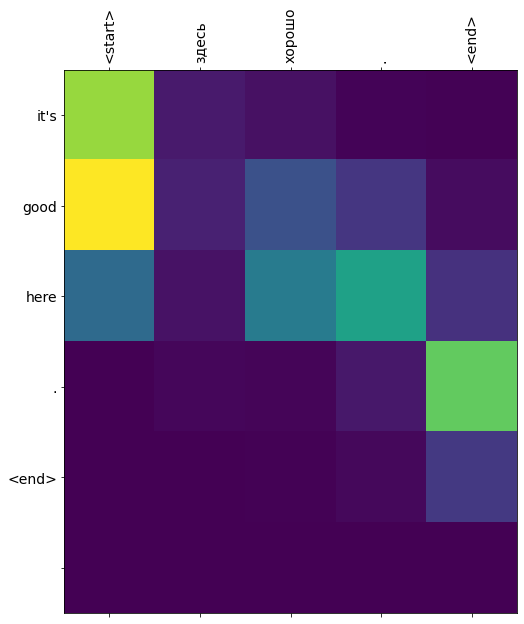

In [ ]:
translate_plot('Здесь хорошо.')

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  #attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  #plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
for sentense in ru[44000:44020]:
  translate(sentense[7:-5])

Input: <start> я ужинаю . <end>
Predicted translation: i'm having dinner . <end> 
Input: <start> я здесь , чтобы научиться . <end>
Predicted translation: i'm here to do . <end> 
Input: <start> я здесь с томом . <end>
Predicted translation: i'm here with tom . <end> 
Input: <start> я надеюсь победить . <end>
Predicted translation: i expect to win . <end> 
Input: <start> я надеюсь выиграть . <end>
Predicted translation: i expect to win . <end> 
Input: <start> я сейчас в бостоне . <end>
Predicted translation: i'm in boston now . <end> 
Input: <start> я в плохом настроении . <end>
Predicted translation: i'm in a bad mood . <end> 
Input: <start> у меня плохое настроение . <end>
Predicted translation: i'm in a bad mood . <end> 
Input: <start> я в хорошей форме . <end>
Predicted translation: i'm in good shape . <end> 
Input: <start> я в пижаме . <end>
Predicted translation: i'm in my pajamas . <end> 
Input: <start> я сейчас в тюрьме . <end>
Predicted translation: i'm in jail now . <end> 
Inpu